# Classifiers

In [2]:
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
%%javascript
 IPython.OutputArea.prototype._should_scroll = function(lines) {
     return false;
 }

<IPython.core.display.Javascript object>

In [4]:
data_path = './datasets'
df_git = pd.read_json('{}/df_git.json'.format(data_path), orient='records', lines=True)

## Re-generate "Train", "Test" and "Validation" data sub-sets

In [5]:
from sklearn.model_selection import train_test_split

# Separate target variable
y_git = df_git.pop('author_bot')

# Divide the Dataset into 60% training and 40% test + validation
X_train_git_og, X_test_tmp_git,\
y_train_git, y_test_tmp_git = train_test_split(df_git, y_git, test_size=0.4,
                                               random_state=22, stratify=y_git)

# From 40% of the original dataset, 25% is for test and 15% is for validation
# This means we have to split the test+validation set in a 62,5%/37,5% ratio

X_test_git_og, X_val_git_og,\
y_test_git, y_val_git = train_test_split(X_test_tmp_git, y_test_tmp_git,
                                         test_size=0.375, random_state=22,
                                         stratify=y_test_tmp_git)

## Apply pre-processing to the datasets

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def log10(x):
    return np.log(x)

def shifted_log10(x):
    return np.log(1 + x)

heuristic_terms = ['auto', 'bot', 'build', 'cd', 'ci', 'code', 'commit', 'copy',
                   'dependency', 'fix', 'integration', 'issue', 'merge', 'patrol',
                   'pr', 'pull', 'release', 'request', 'review', 'sync', 'template',
                   'tool', 'travis']

terms_l1 = ['bot', 'dependency', 'fix', 'merge', 'integration']
terms_l2 = ['build', 'travis', 'copy', 'template', 'sync',  'auto',
            'release', 'review', 'tool', 'issue', 'request', 'commit']
terms_l3 = ['ci', 'cd', 'pr', 'code', 'patrol', 'pull']

def compute_terms_score(x, terms):
    score = 0
    n_l1 = 0
    n_l2 = 0
    n_l3 = 0
    for term in terms:
        if term.lower() in x.lower():
            if term in terms_l1:
                n_l1 += 1
            elif term in terms_l2:
                n_l2 += 1
            elif term in terms_l3:
                n_l3 += 1
    score = 60*n_l1 + 30*n_l2 + 10*n_l3
    norm_score = score  # (100*score)/720
    return norm_score

def preprocess_git_df(git_df):
    new_git_df = pd.DataFrame()
    new_git_df["git__log_num_commits"] = git_df["git__num_commits"].apply(lambda x: log10(x))
    new_git_df["git__log_num_merge_commits"] = git_df["git__num_merge_commits"].apply(lambda x: shifted_log10(x))
    new_git_df["git__log_num_weekend_commits"] = git_df["git__num_weekend_commits"].apply(lambda x: shifted_log10(x))
    new_git_df["git__log_num_signed_commits"] = git_df["git__num_signed_commits"].apply(lambda x: shifted_log10(x))
    
    new_git_df["git__log_num_repos"] = git_df["git__num_repos"].apply(lambda x: log10(x))
    
    # new_git_df["git__sqrt_ratio_merge_commits"] = git_df["git__ratio_merge_commits"].apply(lambda x: np.sqrt(x))
    # new_git_df["git__sqrt_ratio_weekend_commits"] = git_df["git__ratio_weekend_commits"].apply(lambda x: np.sqrt(x))
    
    # new_git_df["git__sqrt_ratio_signed_commits"] = git_df["git__ratio_signed_commits"].apply(lambda x: np.sqrt(x))

    new_git_df["git__log_median_files"] = git_df["git__median_files"].apply(lambda x: shifted_log10(x))
    new_git_df["git__log_iqr_files"] = git_df["git__iqr_files"].apply(lambda x: shifted_log10(x))
    
    new_git_df["git__log_median_lines_added"] = git_df["git__median_lines_added"].apply(lambda x: shifted_log10(x))
    # new_git_df["git__log_iqr_lines_added"] = git_df["git__iqr_lines_added"].apply(lambda x: shifted_log10(x))
    
    new_git_df["git__log_median_lines_removed"] = git_df["git__median_lines_removed"].apply(lambda x: shifted_log10(x))
    # new_git_df["git__log_iqr_lines_removed"] = git_df["git__iqr_lines_removed"].apply(lambda x: shifted_log10(x))
    
    #TODO: Review these two fields
    new_git_df["git__log_median_len_commit_message"] = git_df["git__median_len_commit_message"].apply(lambda x: shifted_log10(x))
    # new_git_df["git__log_iqr_len_commit_message"] = git_df["git__iqr_len_commit_message"].apply(lambda x: shifted_log10(x))
    
    # new_git_df["git__log_median_len_words_commit_message"] = git_df["git__median_len_words_commit_message"].apply(lambda x: shifted_log10(x))
    new_git_df["git__log_iqr_len_words_commit_message"] = git_df["git__iqr_len_words_commit_message"].apply(lambda x: shifted_log10(x))


    # Binary variables
    # new_git_df['git__has_merge_commits'] = (git_df['git__num_merge_commits'] > 0).astype(int)
    # new_git_df['git__has_weekend_commits'] = (git_df['git__num_weekend_commits'] > 0).astype(int)
    # new_git_df['git__has_signed_commits'] = (git_df['git__num_signed_commits'] > 0).astype(int)
    
    #FIXME: Hay que aligerar el modelo. Eliminamos esto pero lo mencionamos en la memoria
    # new_git_df['git__mostly_not_adding_lines'] = (git_df['git__median_lines_added'] == 0).astype(int)
    # new_git_df['git__mostly_not_removing_lines'] = (git_df['git__median_lines_removed'] == 0).astype(int)
    
    new_git_df['terms_score'] = git_df['author_name'].apply(lambda x: compute_terms_score(x, heuristic_terms))
    
    return new_git_df

In [7]:
len(heuristic_terms)

23

In [8]:
X_train_git = preprocess_git_df(X_train_git_og)

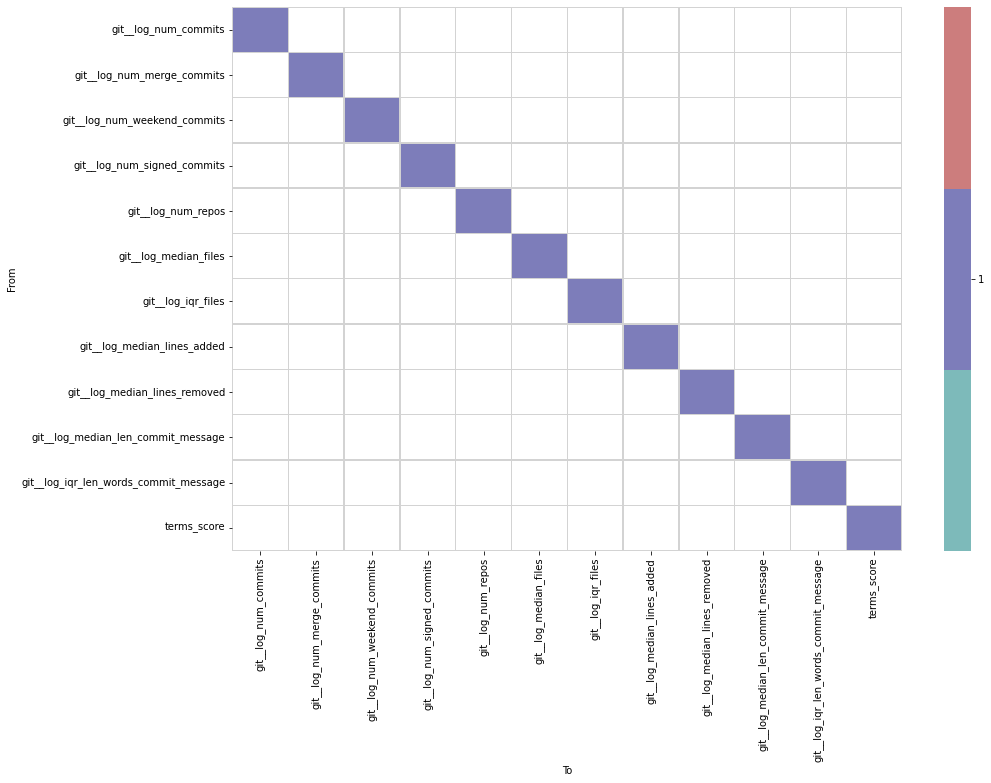

In [9]:
from matplotlib.colors import LinearSegmentedColormap


dfcorr = X_train_git.corr().abs()
kot = dfcorr[dfcorr>=.75]
fig,ax = plt.subplots(1,1,figsize=(15,10))

myColors = ((0.49, 0.73, 0.73, 1.0), (0.49, 0.49, 0.73, 1.0), (0.8, 0.49, 0.49, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

ax = sns.heatmap(kot, cmap=cmap, linewidths=.5, linecolor='lightgray')

# Manually specify colorbar labelling after it's been generated
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-1, 0, 1])
colorbar.set_ticklabels(['-1', '0', '1'])

# X - Y axis labels
ax.set_ylabel('From')
ax.set_xlabel('To')

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
_, labels = plt.yticks()
plt.setp(labels, rotation=0)

plt.show()

#sns.heatmap(kot, cmap="Set1", vmin=0, vmax=1, ax=ax)



In [10]:
X_test_git = preprocess_git_df(X_test_git_og)

In [11]:
X_train_git

,git__log_num_commits,git__log_num_merge_commits,git__log_num_weekend_commits,git__log_num_signed_commits,git__log_num_repos,git__log_median_files,git__log_iqr_files,git__log_median_lines_added,git__log_median_lines_removed,git__log_median_len_commit_message,git__log_iqr_len_words_commit_message,terms_score
2352,7.080868,2.302585,5.986452,0.000000,5.087596,0.693147,1.098612,1.791759,1.098612,5.129899,2.564949,0
2985,6.453625,5.497168,5.442418,0.000000,0.000000,0.693147,0.693147,0.693147,0.000000,4.158883,2.197225,0
390,2.772589,0.000000,1.098612,0.000000,1.791759,0.693147,0.810930,1.504077,1.098612,5.117994,2.197225,0
1164,3.737670,1.098612,1.945910,0.000000,0.693147,0.693147,0.000000,1.098612,0.693147,3.891820,2.014903,0
2935,2.484907,0.000000,0.000000,0.000000,0.693147,1.386294,0.916291,3.465736,0.693147,5.249652,2.442347,0
...,...,...,...,...,...,...,...,...,...,...,...,...
527,2.564949,1.098612,0.000000,0.000000,1.791759,1.098612,1.945910,4.007333,1.098612,4.955827,2.564949,0
3316,2.302585,0.000000,0.000000,0.000000,0.000000,0.693147,0.559616,1.704748,1.386294,2.917771,1.178655,0
871,2.944439,0.000000,0.000000,2.944439,1.098612,0.693147,0.916291,1.945910,1.609438,4.955827,2.442347,0
195,2.397895,0.000000,0.000000,0.000000,1.098612,0.693147,1.098612,0.916291,0.916291,5.075174,2.197225,0


## Apply techniques to mitigate the effect of unbalanced data

In [12]:
from imblearn.over_sampling import SMOTE

In [13]:
smt = SMOTE(random_state=22)
X_train_git_SMOTE, y_train_git_SMOTE = smt.fit_resample(X_train_git, y_train_git)

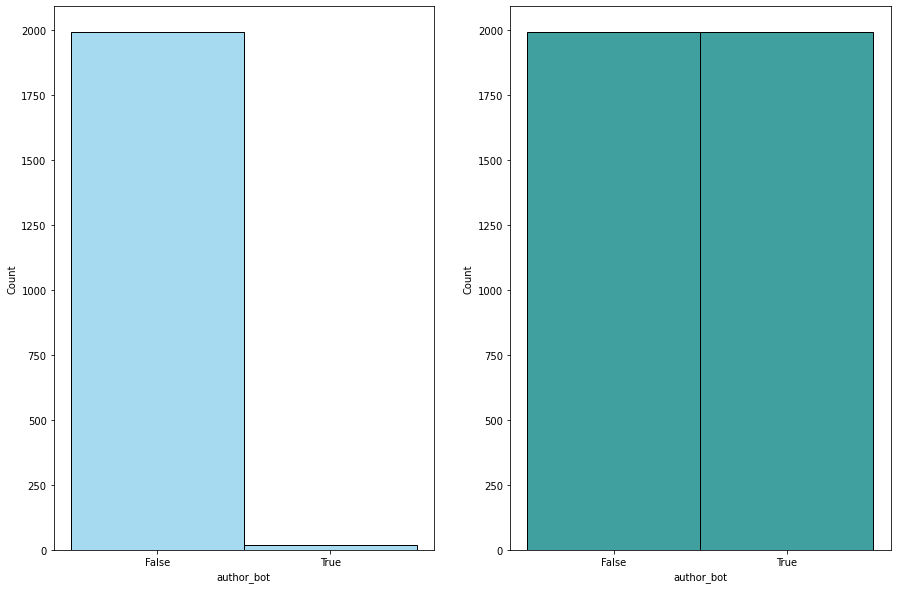

In [14]:
# Documentation: https://seaborn.pydata.org/generated/seaborn.histplot.html
fig, axs = plt.subplots(1, 2, figsize=(15,10))

sns.histplot(data=y_train_git.replace({0: 'False', 1: 'True'}), stat='count', kde=False, color="skyblue", ax=axs[0])
sns.histplot(data=y_train_git_SMOTE.replace({0: 'False', 1: 'True'}), stat='count', kde=False, discrete=True, color="teal", ax=axs[1])

plt.show()

## Study classes' distribution

In [15]:
from time import time

import numpy as np
import pandas as pd


# For plotting
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import plotly.graph_objects as go

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

#For standardising the dat
from sklearn.preprocessing import StandardScaler

#PCA
from sklearn.manifold import TSNE

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [16]:
standardized_data = StandardScaler().fit_transform(X_train_git)
print(standardized_data.shape)


(2008, 12)


In [17]:
%time
tsne = TSNE(random_state = 22, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(X_train_git)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11 µs


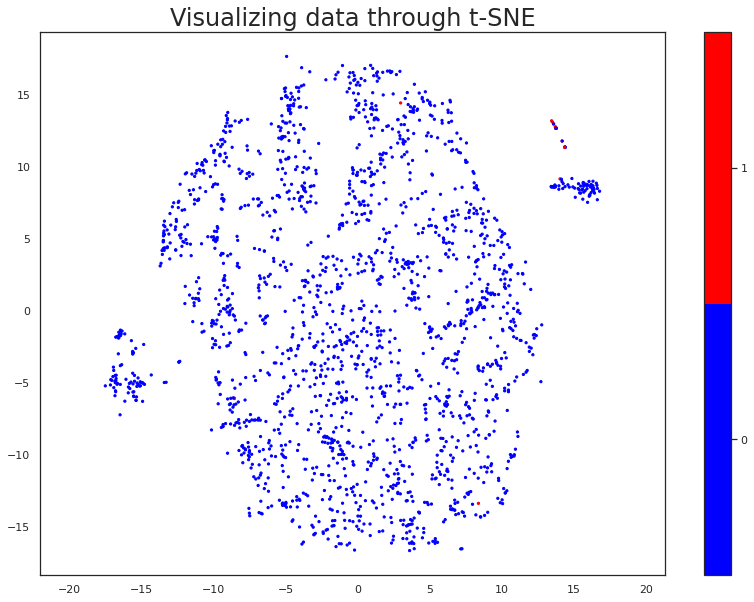

In [18]:
plt.scatter(tsne[:, 0], tsne[:, 1], s=5, c=y_train_git, cmap='bwr')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('Visualizing data through t-SNE', fontsize=24);

# plt.savefig('data-tsne.png', dpi=600, transparent=True)

In [19]:
standardized_data_SMOTE = StandardScaler().fit_transform(X_train_git_SMOTE)
print(standardized_data_SMOTE.shape)


(3982, 12)


In [20]:
%time
tsne_SMOTE = TSNE(random_state = 22, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(X_train_git_SMOTE)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


Text(0.5, 1.0, 'Visualizing data through t-SNE w/SMOTE')

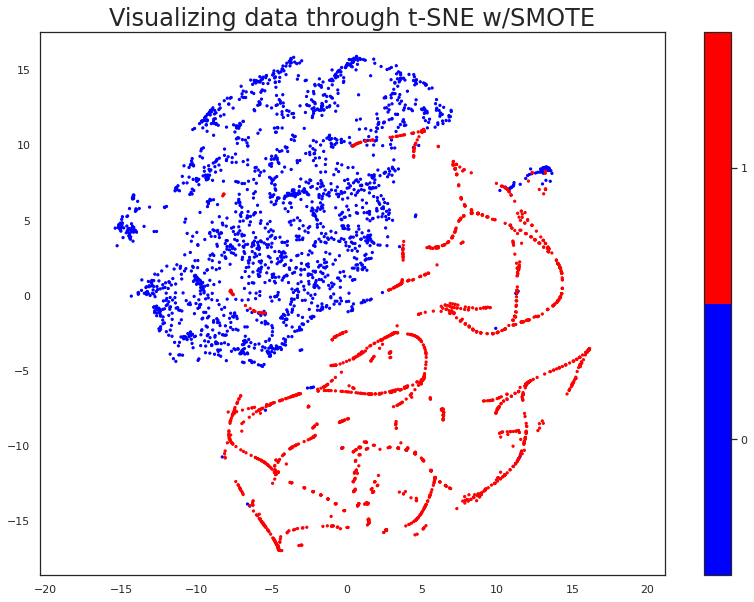

In [21]:
plt.scatter(tsne_SMOTE[:, 0], tsne_SMOTE[:, 1], s= 5, c=y_train_git_SMOTE, cmap='bwr')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('Visualizing data through t-SNE w/SMOTE', fontsize=24)

# plt.savefig('data-tsne-smote.png', dpi=600, transparent=True)

## Testing classifiers

In [22]:
from sklearn.naive_bayes import ComplementNB, GaussianNB
import sklearn.metrics
from sklearn.metrics import auc,\
                            classification_report,\
                            precision_score,\
                            recall_score,\
                            accuracy_score,\
                            fbeta_score,\
                            roc_curve,\
                            roc_auc_score,\
                            ConfusionMatrixDisplay,\
                            plot_roc_curve,\
                            plot_confusion_matrix,\
                            balanced_accuracy_score

from yellowbrick.classifier import classification_report,\
                                   confusion_matrix,\
                                   roc_auc,\
                                   precision_recall_curve,\
                                   class_prediction_error,\
                                   discrimination_threshold

In [23]:
def print_model_report_old(model, X_test, y_test, y_pred):
    print("Classification report:")
    print("------------------------------------------")
    print("accuracy", accuracy_score(y_test, y_pred))
    print("------------------------------------------")
    print("F-2 score", fbeta_score(y_test, y_pred, beta=2))
    print("------------------------------------------")
    print("AUC")
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    print(auc(fpr, tpr))
    print("------------------------------------------")
    print(sklearn.metricsclassification_report(y_test, y_pred))
    print("------------------------------------------")
    print("Confusion matrix (author_bot):")
    plot_confusion_matrix(model, X_test, y_test)
    plt.grid(False)
    plt.show()
    print("------------------------------------------")
    print("ROC curve (author_bot):")
    plot_roc_curve(model, X_test, y_test)
    plt.show()

In [24]:
                            
def print_model_report(model, X_train, y_train, X_test, y_test):

    model_name = type(model).__name__
    print(model_name)

    """
    print("------------------------------------------")
    print("Classification report:")
    classification_report(model, X_train, y_train, X_test, y_test)
    """
    
    print("------------------------------------------")
    print("Confusion matrix:")
    confusion_matrix(model, X_train, y_train, X_test, y_test)
    
    """
    print("------------------------------------------")
    print("Misclassified:")
    print(np.where(y_test != model.predict(X_test)))
    """
    
    print("------------------------------------------")
    print("Scores:")
    y_pred = model.predict(X_test)
    f2_score = round(fbeta_score(y_test, y_pred, beta=2), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    print('\tprecision: {}\n\trecall: {}\n\tf2-score: {}'.format(precision, recall, f2_score))
    return precision, recall, f2_score
    


In [25]:
df_scores = pd.DataFrame()
def add_score_to_df(scores_dataframe, model_name, model_subset, results):
    precision = results[0]
    recall = results[1]
    f2_score = results[2]
    new_row = pd.Series({'model_subset': model_subset,
                         'model_name': model_name,
                         'precision_score': round(precision, 3),
                         'recall_score': round(recall, 3),
                         'f2_score': round(f2_score, 3)})
    return pd.concat([df_scores, new_row.to_frame().T], ignore_index=True)

## Gaussian Naïve-Bayes

According to Scikit-learn documentation, `GaussianNB` implements the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian.

GaussianNB
------------------------------------------
Confusion matrix:


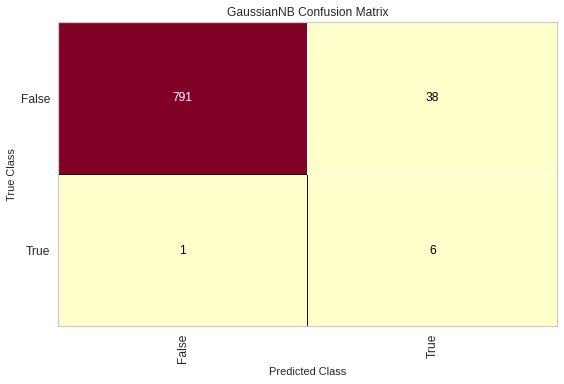

------------------------------------------
Scores:
	precision: 0.136
	recall: 0.857
	f2-score: 0.417


In [26]:
# Gaussian Naive-Bayes

gnb = GaussianNB().fit(X_train_git_SMOTE, y_train_git_SMOTE)
y_pred_gnb = gnb.predict(X_test_git)

precision, recall, f2_score = print_model_report(gnb, X_train_git_SMOTE, y_train_git_SMOTE, X_test_git, y_test_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'Gaussian Naive-Bayes', 'Test', results)

Complement NB

ComplementNB
------------------------------------------
Confusion matrix:


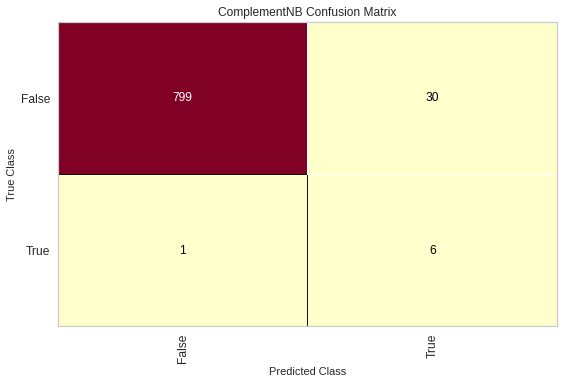

------------------------------------------
Scores:
	precision: 0.167
	recall: 0.857
	f2-score: 0.469


In [27]:
cnb = ComplementNB(norm=True).fit(X_train_git_SMOTE, y_train_git_SMOTE)
y_pred_cnb = cnb.predict(X_test_git)

precision, recall, f2_score = print_model_report(cnb, X_train_git_SMOTE, y_train_git_SMOTE, X_test_git, y_test_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'Complement Naive-Bayes', 'Test', results)

### Support Vector Machines

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

`LinearSVC` (Linear Support Vector Classification) is a faster implementation of Support Vector Classification for the case of a linear kernel.

In [28]:
from sklearn.svm import SVC, LinearSVC

LinearSVC
------------------------------------------
Confusion matrix:


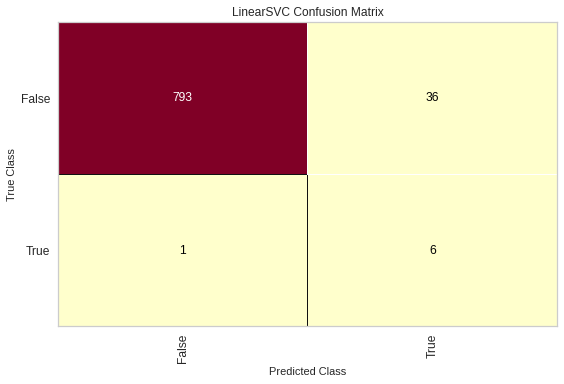

------------------------------------------
Scores:
	precision: 0.143
	recall: 0.857
	f2-score: 0.429


In [29]:
# SVC
lsvc = LinearSVC(random_state=22)

lsvc.fit(X_train_git_SMOTE, y_train_git_SMOTE)

y_pred_lsvc = lsvc.predict(X_test_git)

precision, recall, f2_score =  print_model_report(lsvc, X_train_git_SMOTE, y_train_git_SMOTE, X_test_git, y_test_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'LinearSVC', 'Test', results)

### K-Nearest Neighbors

KNeighborsClassifier
------------------------------------------
Confusion matrix:


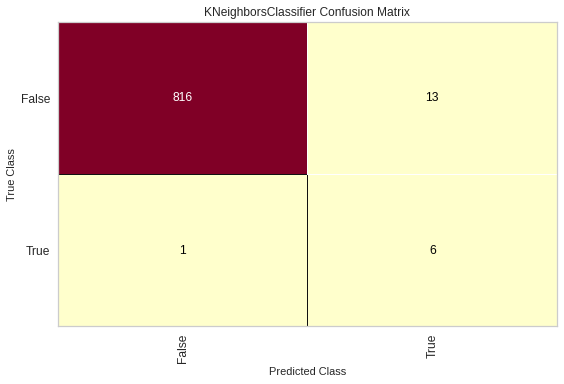

------------------------------------------
Scores:
	precision: 0.316
	recall: 0.857
	f2-score: 0.638


In [30]:
# Knn

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=115)
knn.fit(X_train_git_SMOTE, y_train_git_SMOTE)

y_pred_knn = knn.predict(X_test_git)

precision, recall, f2_score = print_model_report(knn, X_train_git_SMOTE, y_train_git_SMOTE, X_test_git, y_test_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'KNN', 'Test', results)

### Decision Tree

DecisionTreeClassifier
------------------------------------------
Confusion matrix:


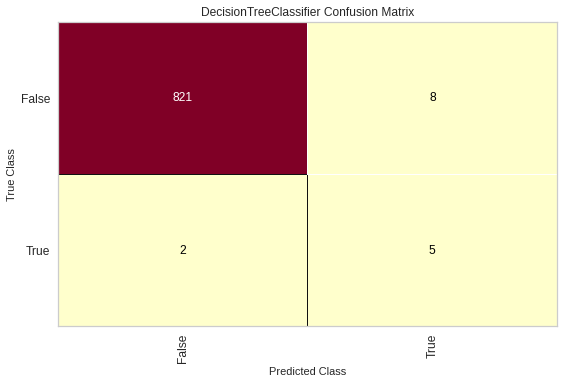

------------------------------------------
Scores:
	precision: 0.385
	recall: 0.714
	f2-score: 0.61


In [31]:
from sklearn.tree import DecisionTreeClassifier

# criterion='gini'

dt = DecisionTreeClassifier(random_state=22, max_depth=5)
dt.fit(X_train_git_SMOTE, y_train_git_SMOTE)

y_pred_dt = dt.predict(X_test_git)

precision, recall, f2_score = print_model_report(dt, X_train_git_SMOTE, y_train_git_SMOTE, X_test_git, y_test_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'Decision Tree', 'Test', results)

#### Represent decision tree

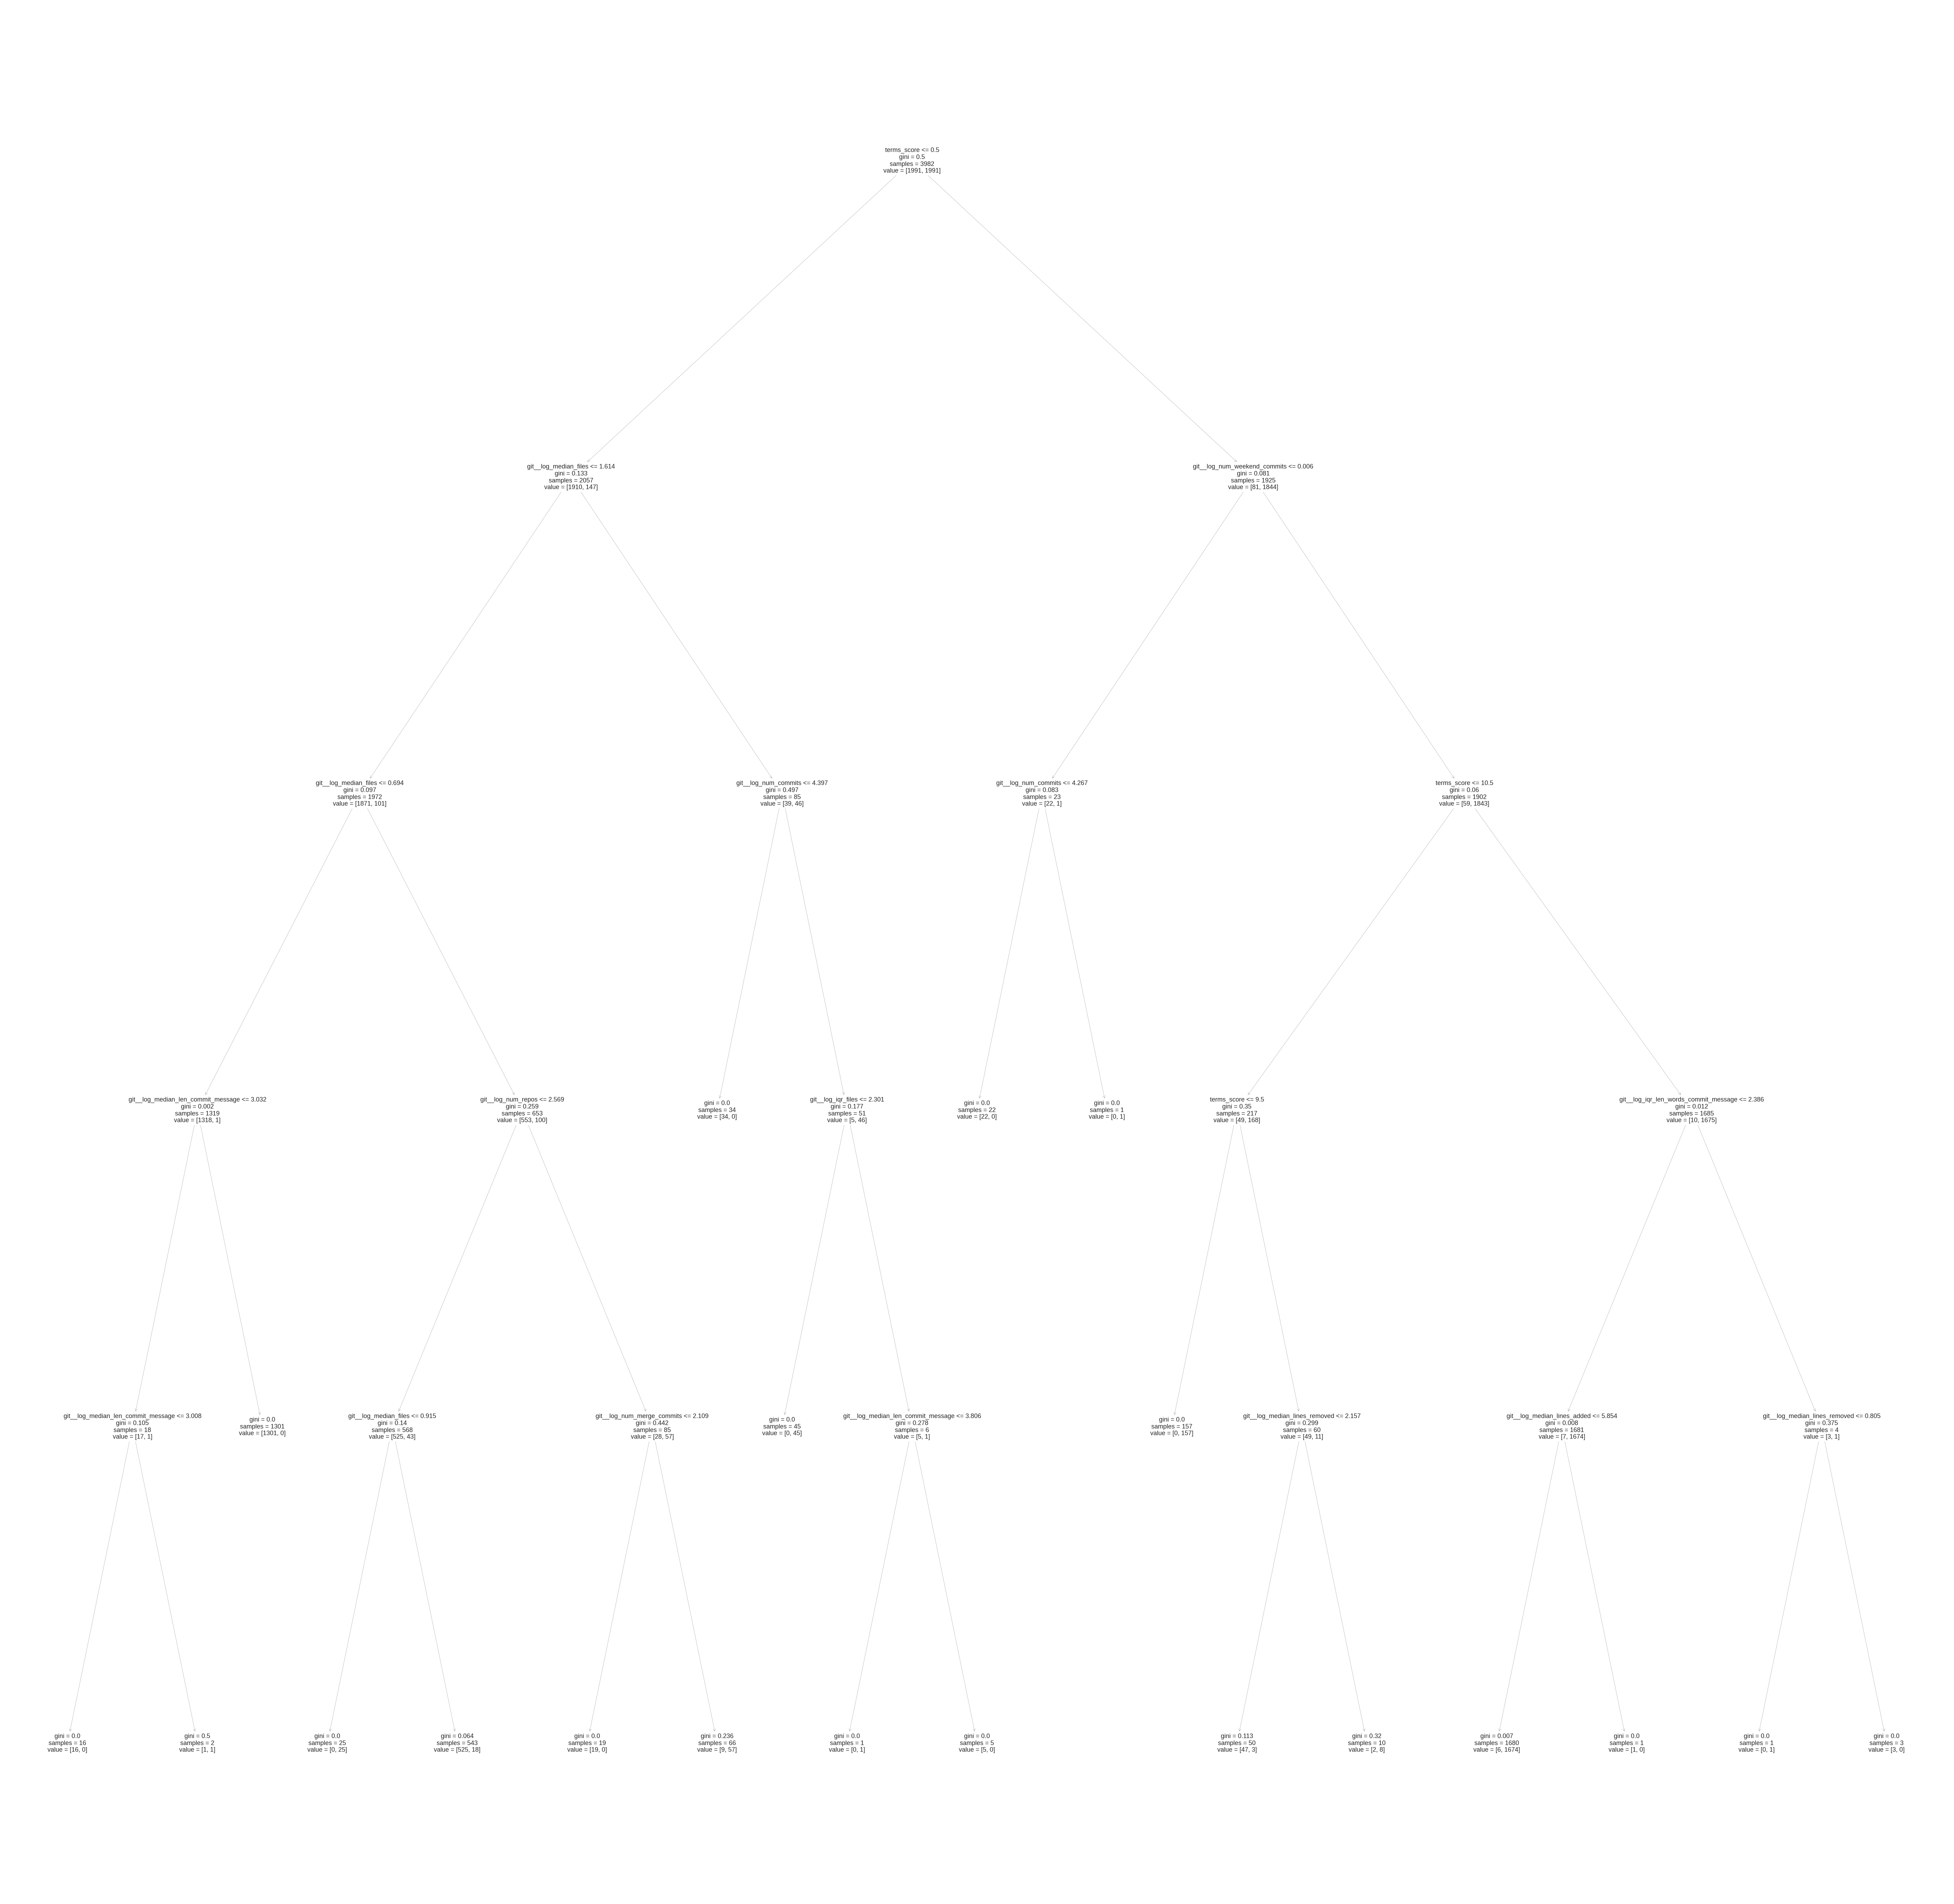

In [32]:
from sklearn import tree

plt.figure(figsize=(100,100))
tree.plot_tree(dt, feature_names=list(X_train_git_SMOTE.columns), fontsize=18)
plt.show()

### Random forest


In [33]:
from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier
------------------------------------------
Confusion matrix:


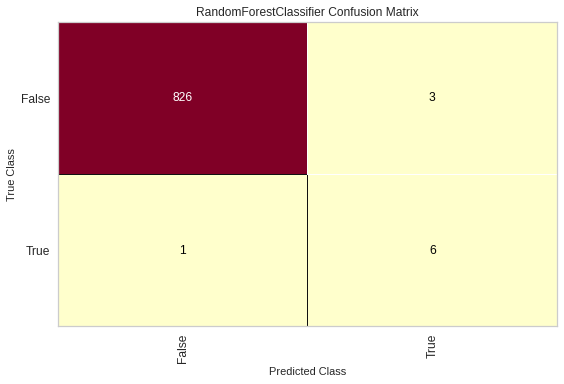

------------------------------------------
Scores:
	precision: 0.667
	recall: 0.857
	f2-score: 0.811


In [34]:
##### Random forest: hyperparameters

rf_adj = RandomForestClassifier(n_estimators=300, criterion='gini', random_state=22, max_depth=4)
rf_adj.fit(X_train_git_SMOTE, y_train_git_SMOTE)

y_pred_rf_adj = rf_adj.predict(X_test_git)

precision, recall, f2_score = print_model_report(rf_adj, X_train_git_SMOTE, y_train_git_SMOTE, X_test_git, y_test_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'Random Forest', 'Test', results)

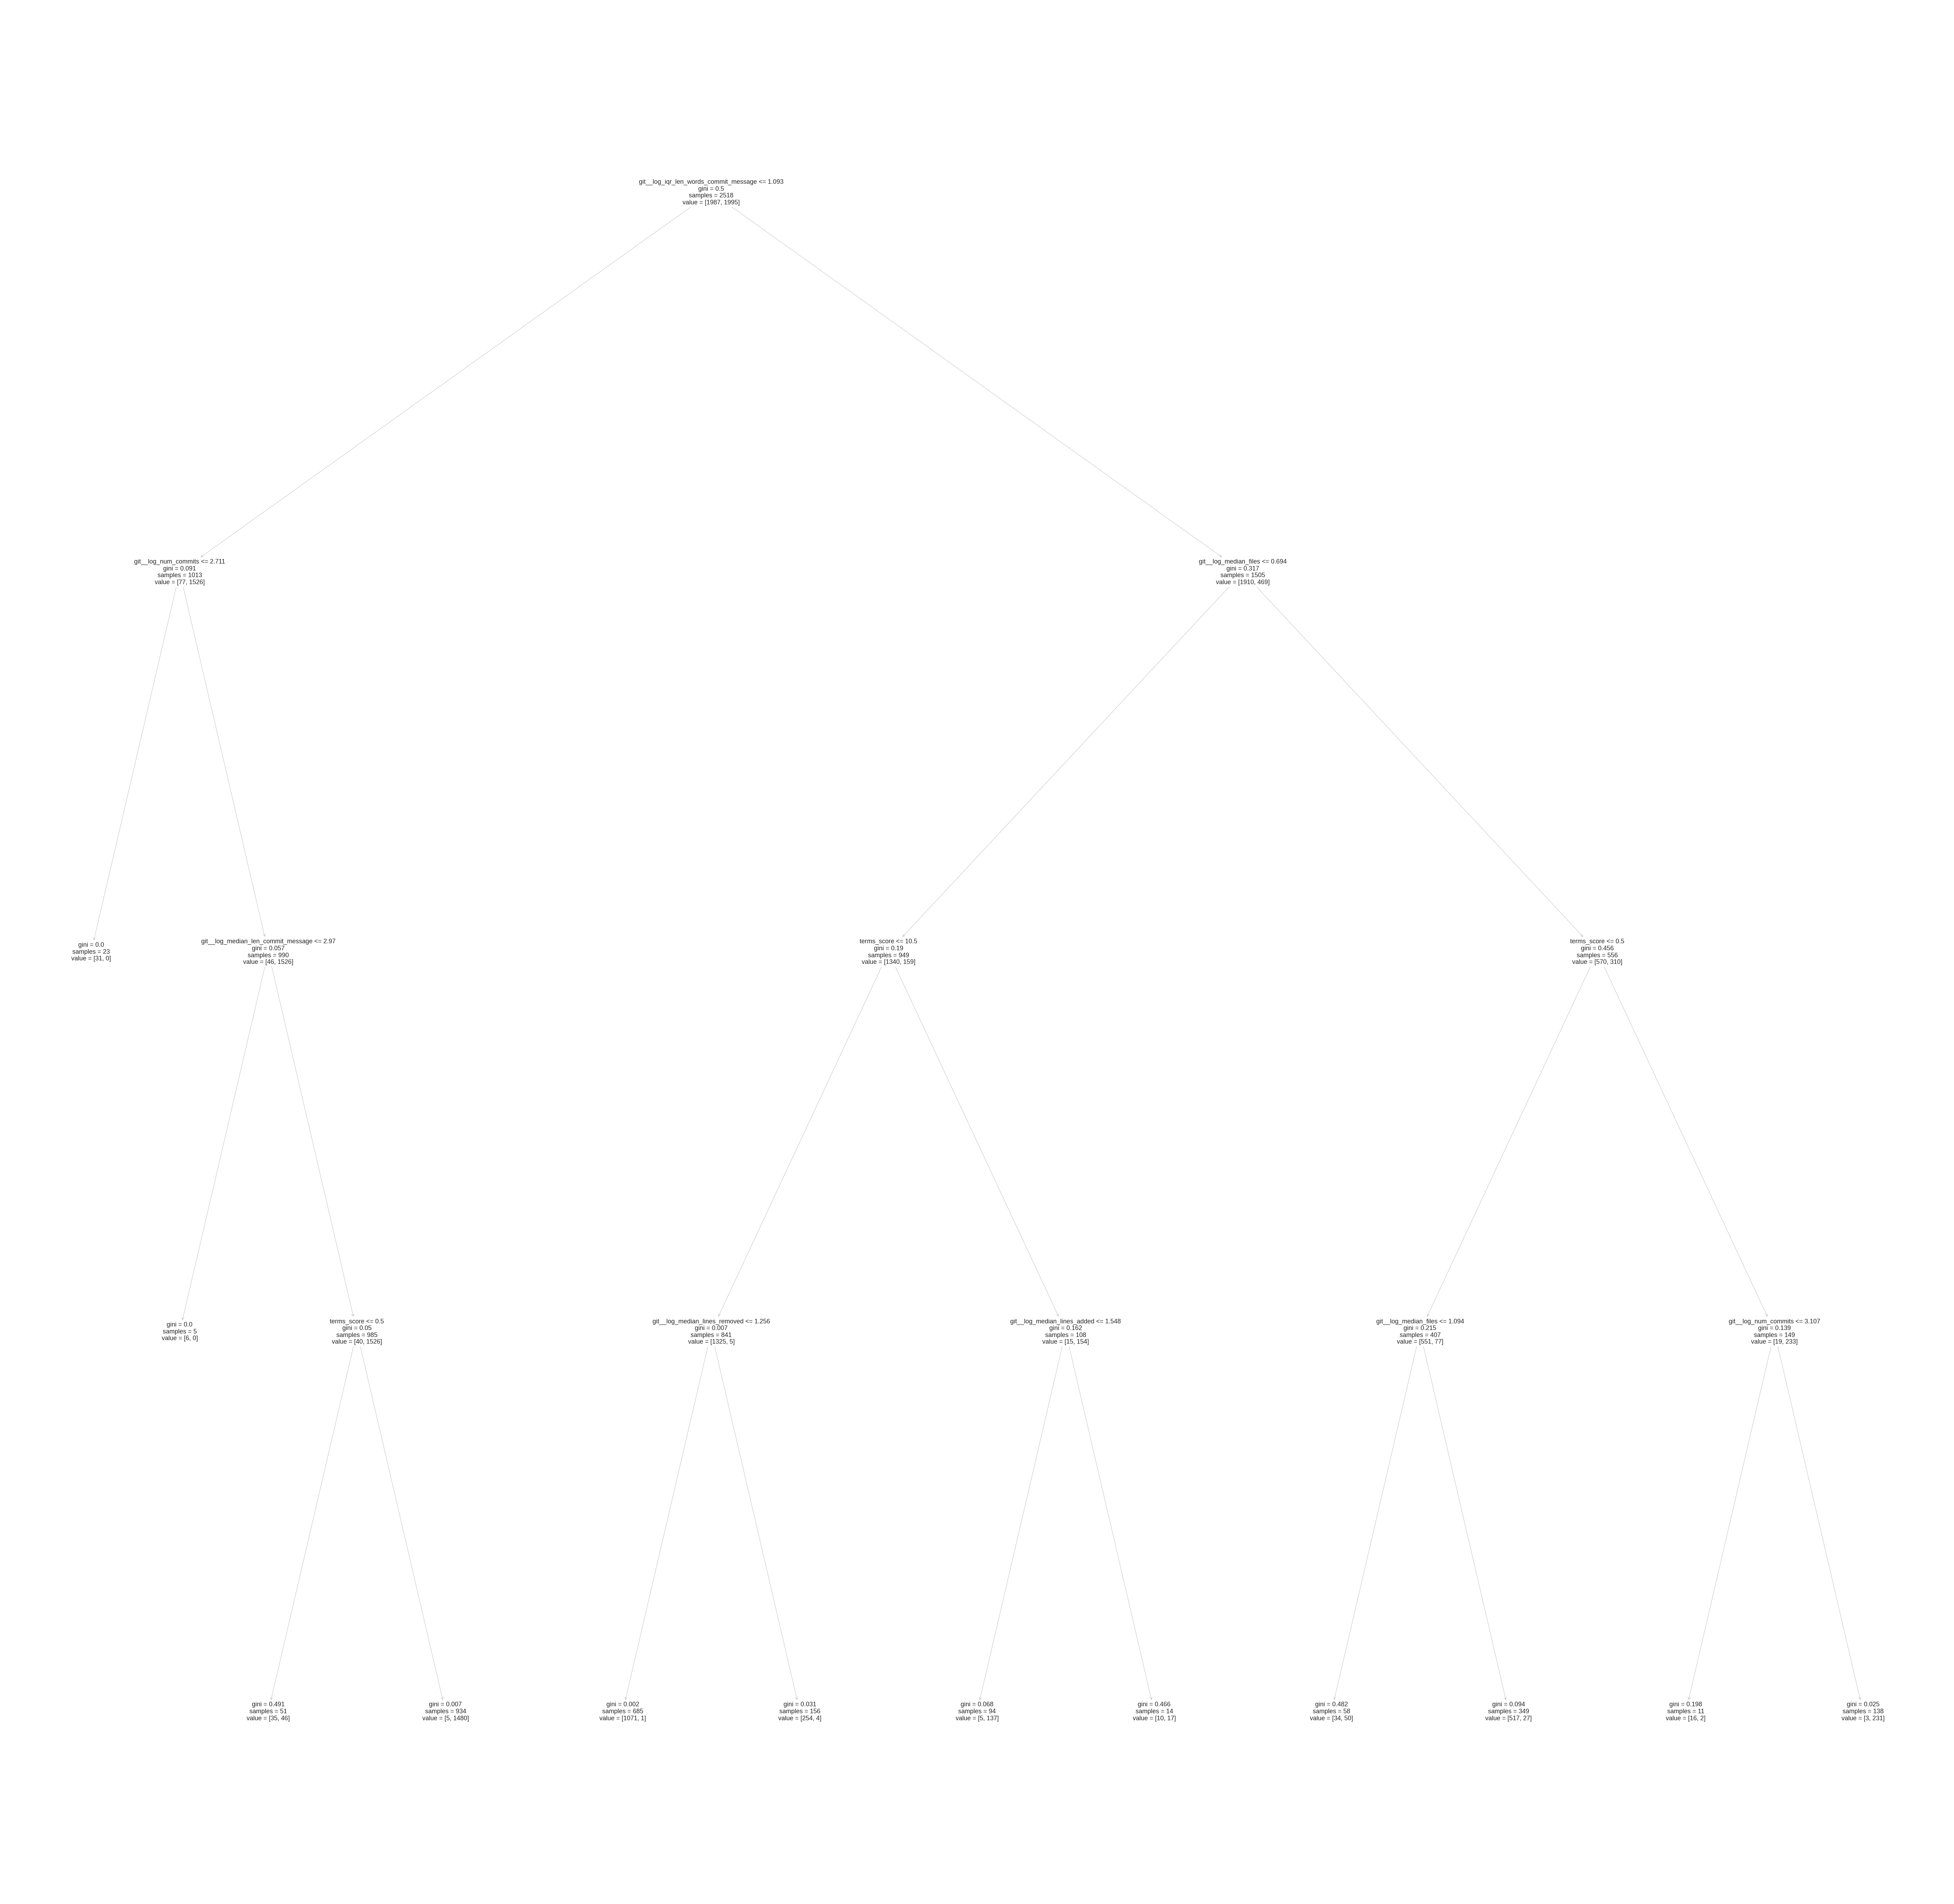

In [35]:
plt.figure(figsize=(100,100))
tree.plot_tree(rf_adj[22], feature_names=list(X_train_git_SMOTE.columns), fontsize=18)
plt.show()

### XGBoost

In [36]:
import xgboost as xgb
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier

[12:22:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier
------------------------------------------
Confusion matrix:


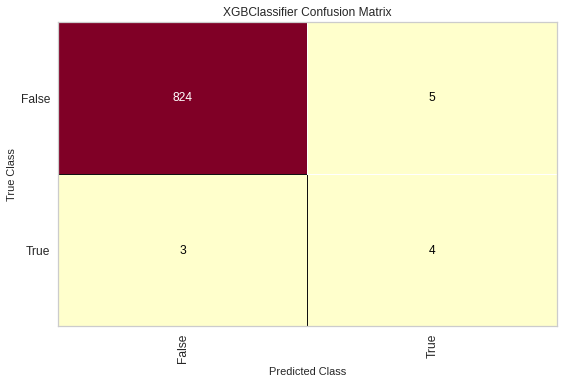

------------------------------------------
Scores:
	precision: 0.444
	recall: 0.571
	f2-score: 0.541


In [37]:
xgb_adj = xgb.XGBClassifier(n_estimators=150, max_depth=4, booster='gbtree', objective='binary:logistic', seed=22)
xgb_adj.fit(X_train_git_SMOTE, y_train_git_SMOTE)

y_pred_xgb_adj = xgb_adj.predict(X_test_git)

precision, recall, f2_score = print_model_report(xgb_adj, X_train_git_SMOTE, y_train_git_SMOTE, X_test_git, y_test_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'XGBoost', 'Test', results)

## Feature importance

<AxesSubplot:title={'center':'Feature Importances of 12 Features using RandomForestClassifier'}, xlabel='relative importance'>

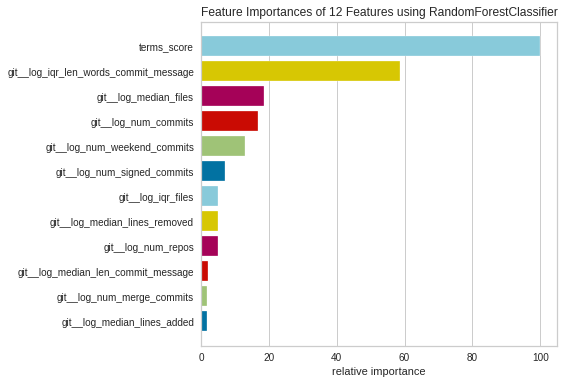

In [38]:
from yellowbrick.datasets import load_occupancy
from yellowbrick.model_selection import FeatureImportances

viz = FeatureImportances(rf_adj)
viz.fit(X_test_git, y_test_git)
viz.show(outpath="rf-feature-importances_test.png", dpi=600)

### Compare results

In [39]:
df_scores

,model_subset,model_name,precision_score,recall_score,f2_score
0,Test,Gaussian Naive-Bayes,0.136,0.857,0.417
1,Test,Complement Naive-Bayes,0.167,0.857,0.469
2,Test,LinearSVC,0.143,0.857,0.429
3,Test,KNN,0.316,0.857,0.638
4,Test,Decision Tree,0.385,0.714,0.61
5,Test,Random Forest,0.667,0.857,0.811
6,Test,XGBoost,0.444,0.571,0.541


### Study correlations

In [40]:
print(X_train_git_SMOTE['git__log_median_files'].corr(X_train_git_SMOTE['git__log_iqr_files']))

0.6813427785957558


# Validate results

#### Evaluate model

##### K-fold cross validation

In [41]:
# K-fold corss validation
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

In [42]:
# Define K-Fold Cross Validation
cv = KFold(n_splits=5, random_state=22, shuffle=True)

# Define scoring function

f_two_scorer = make_scorer(fbeta_score, beta=2)

scoring_dict = {
    'f2_score': f_two_scorer
}

# Evaluate model
scores = cross_validate(rf_adj, X_train_git_SMOTE, y_train_git_SMOTE, scoring=scoring_dict, cv=cv, n_jobs=-1, return_train_score=True)

# Report Performance
scores

{'fit_time': array([2.11176801, 2.20293641, 2.20495582, 2.11746359, 2.00297928]),
 'score_time': array([0.12618542, 0.12359095, 0.12956452, 0.1692369 , 0.12608695]),
 'test_f2_score': array([0.95722483, 0.96653347, 0.95643465, 0.95477387, 0.96806893]),
 'train_f2_score': array([0.96206983, 0.95899975, 0.96268562, 0.96246513, 0.9662751 ])}

## Chosen model: Randon Forest Classifier (to be confirmed)

In [43]:
# X_val_git_og, y_val_git

X_val_git = preprocess_git_df(X_val_git_og)

RandomForestClassifier
------------------------------------------
Confusion matrix:


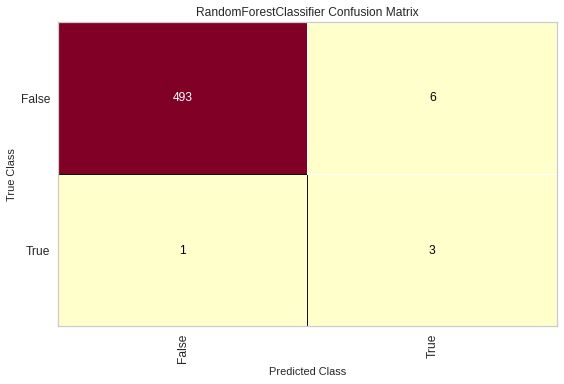

------------------------------------------
Scores:
	precision: 0.333
	recall: 0.75
	f2-score: 0.6


In [44]:

y_pred_rf_adj_val = rf_adj.predict(X_val_git)

precision, recall, f2_score = print_model_report(rf_adj, X_train_git_SMOTE, y_train_git_SMOTE, X_val_git, y_val_git)
results = [precision, recall, f2_score]
df_scores = add_score_to_df(df_scores, 'Random Forest', 'Validation', results)

<AxesSubplot:title={'center':'Feature Importances of 12 Features using RandomForestClassifier'}, xlabel='Relative importance (coefficient)'>

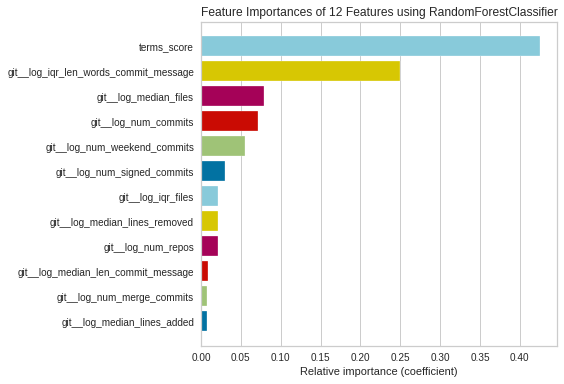

In [61]:
viz = FeatureImportances(rf_adj, xlabel='Relative importance (coefficient)', relative=False)
viz.fit(X_val_git, y_val_git)
viz.show(outpath="rf-feature-importances_val.png", dpi=600)

In [46]:
df_scores.to_csv('df_scores-2023-01.csv')
df_scores

,model_subset,model_name,precision_score,recall_score,f2_score
0,Test,Gaussian Naive-Bayes,0.136,0.857,0.417
1,Test,Complement Naive-Bayes,0.167,0.857,0.469
2,Test,LinearSVC,0.143,0.857,0.429
3,Test,KNN,0.316,0.857,0.638
4,Test,Decision Tree,0.385,0.714,0.61
5,Test,Random Forest,0.667,0.857,0.811
6,Test,XGBoost,0.444,0.571,0.541
7,Validation,Random Forest,0.333,0.75,0.6


## Precision-Recall Curves

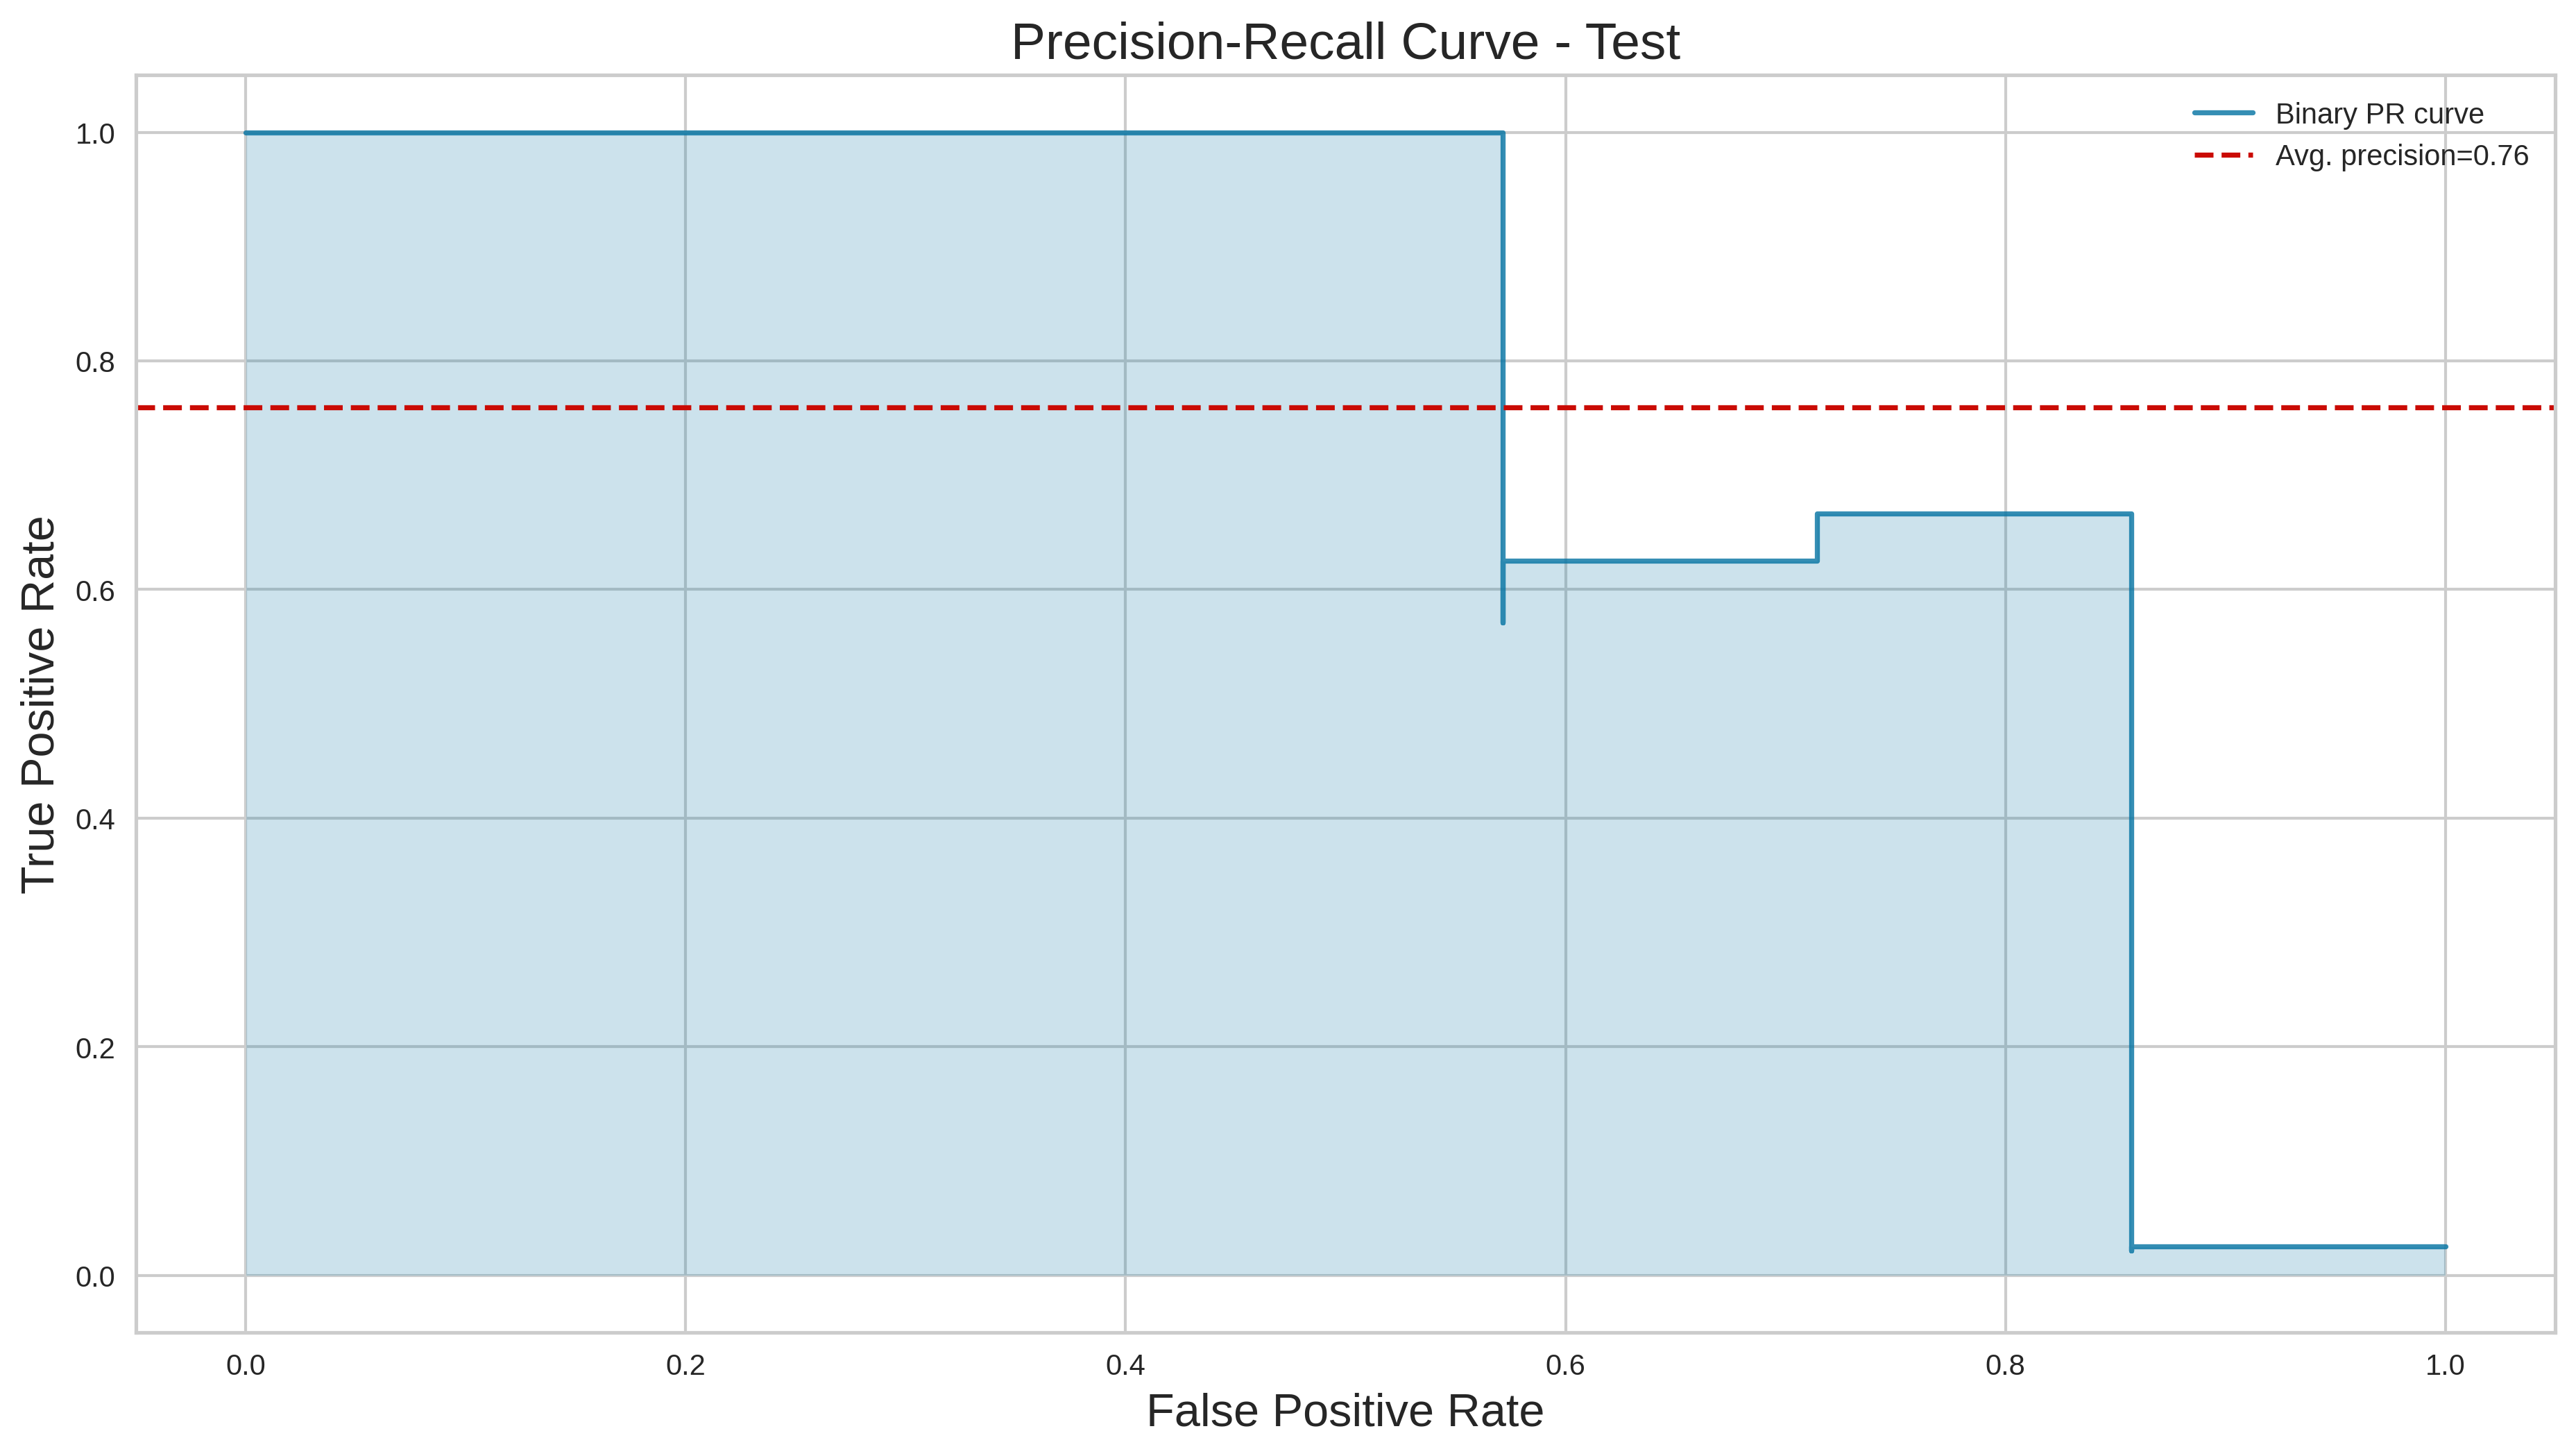

In [47]:
from yellowbrick.classifier import PrecisionRecallCurve

plt.figure(figsize=(15,8), dpi=300)
plt.title("Precision-Recall Curve - Test", fontsize=18)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)

visualizer = PrecisionRecallCurve(rf_adj, classes=["Human", "Bot"])
visualizer.fit(X_train_git_SMOTE, y_train_git_SMOTE)
visualizer.score(X_test_git, y_test_git)

plt.legend()


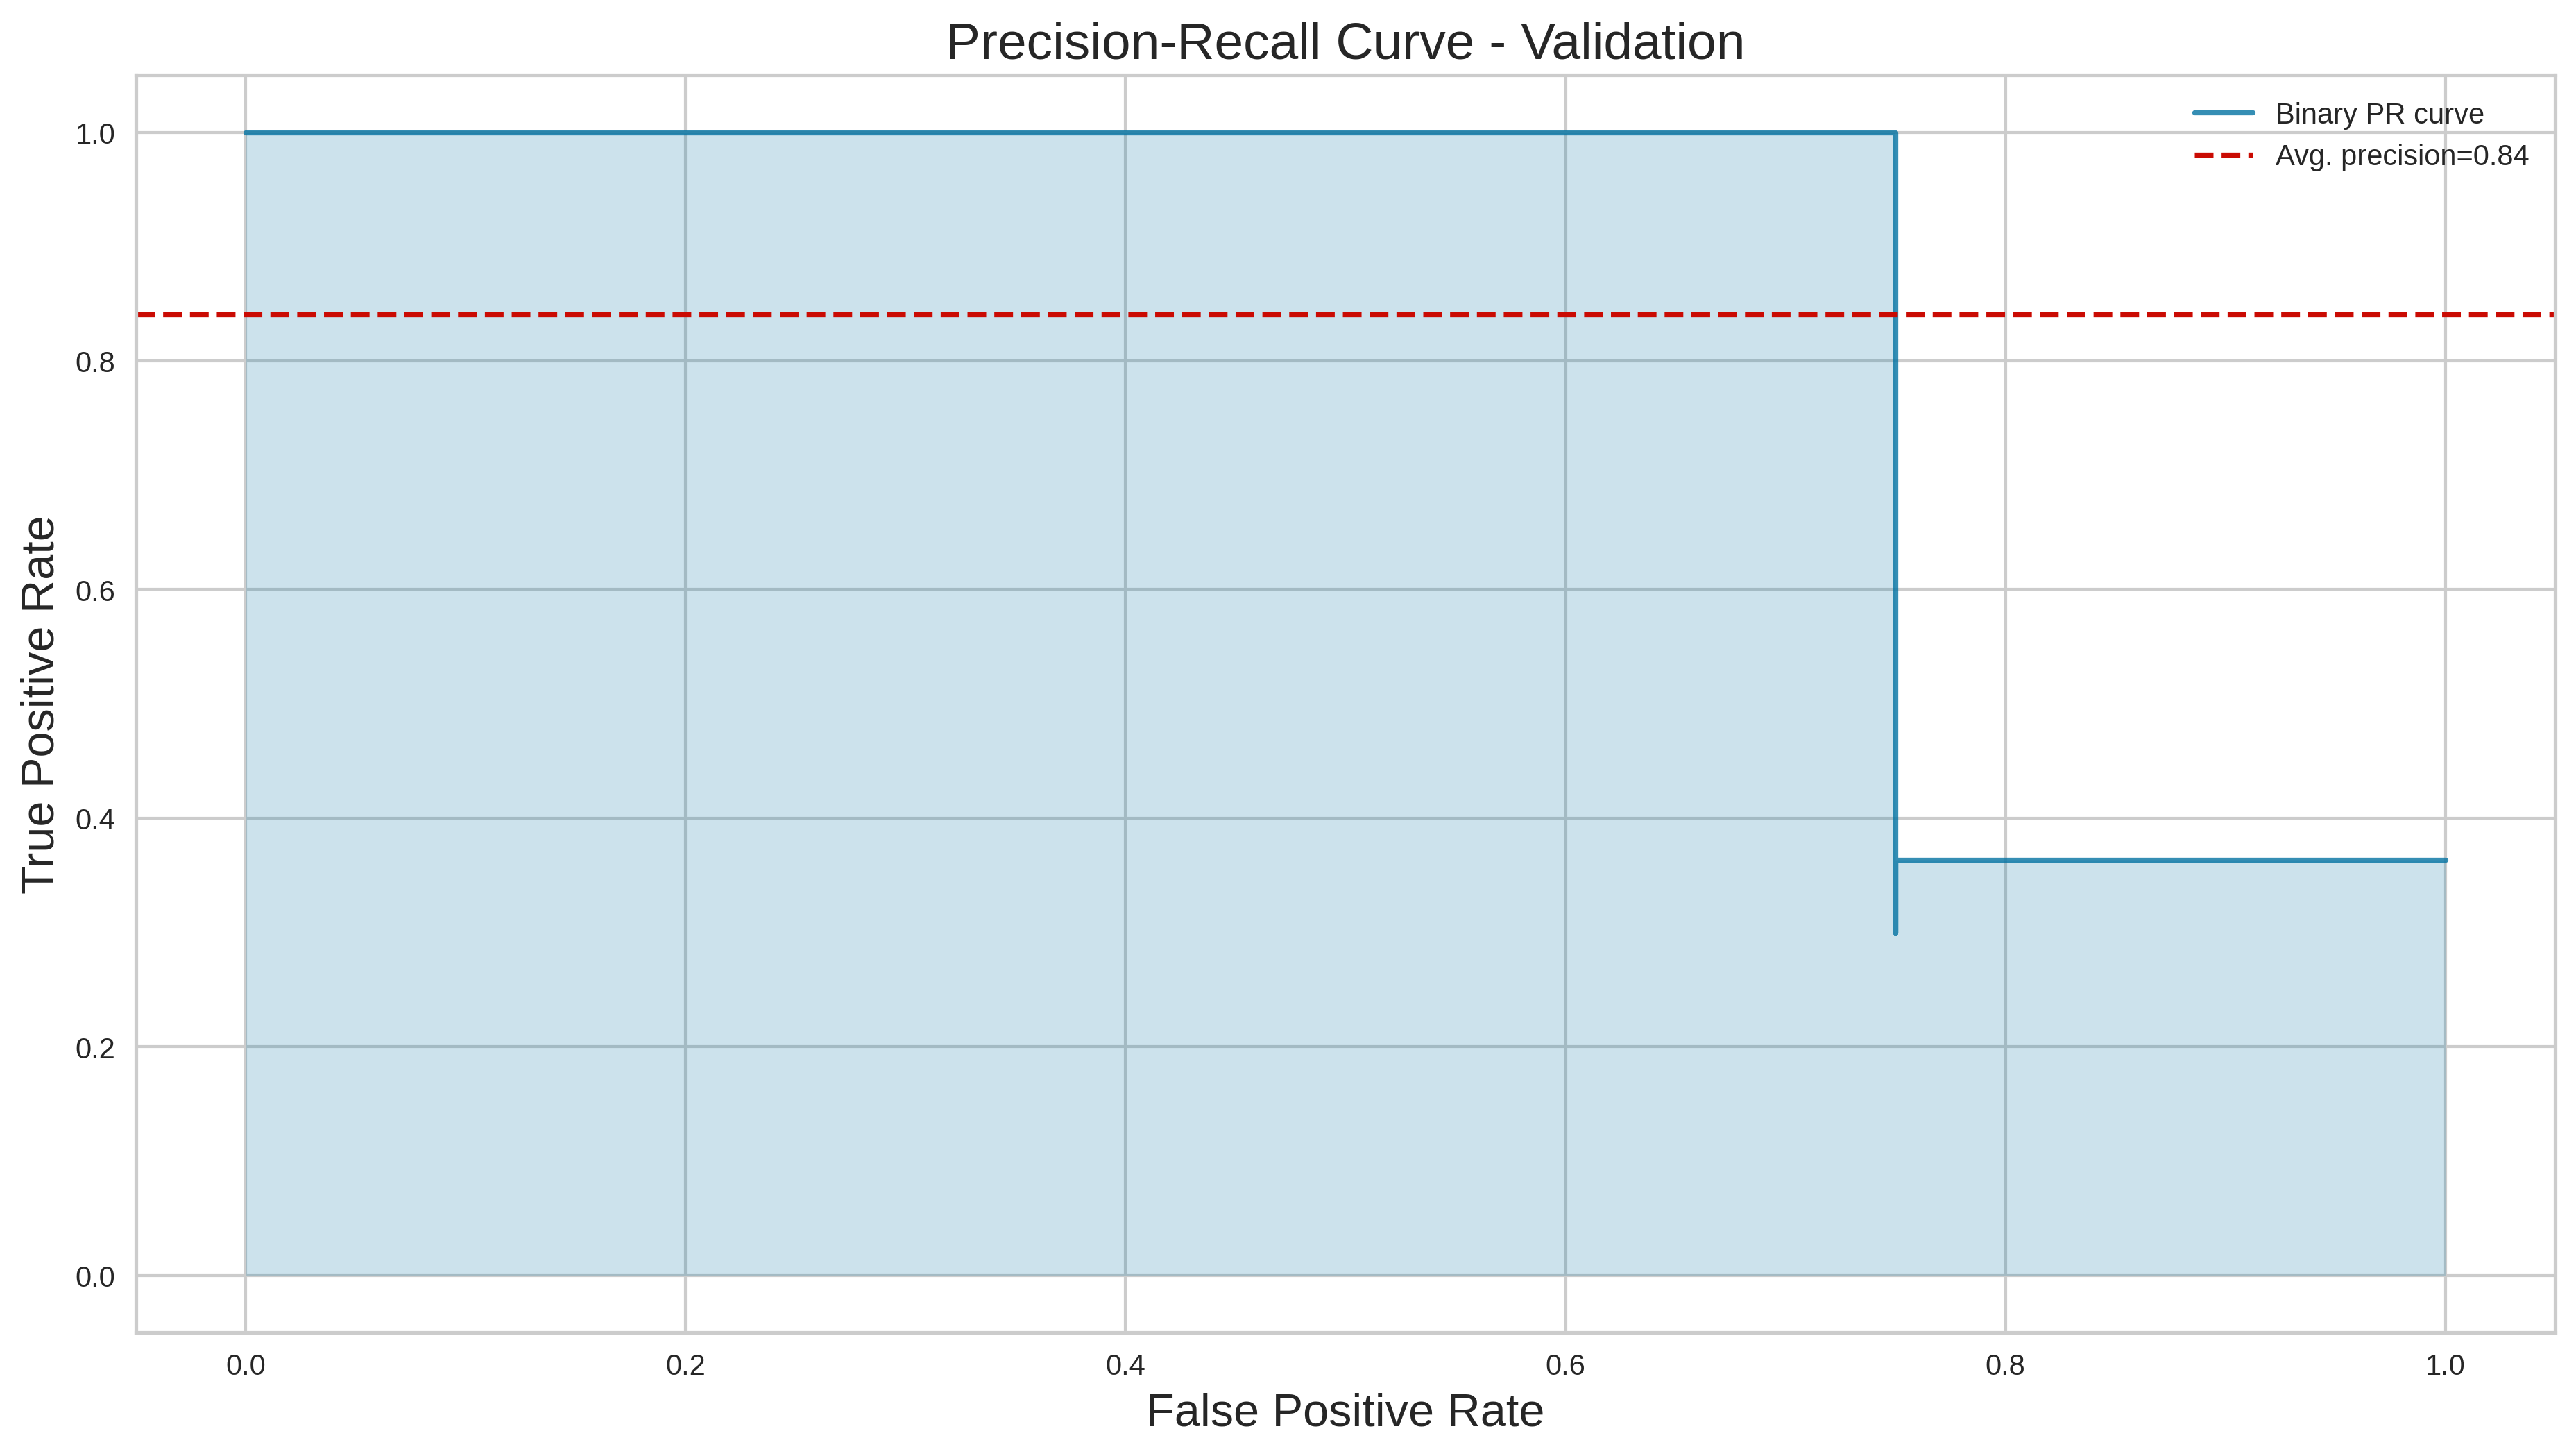

In [48]:
plt.figure(figsize=(15,8), dpi=300)
plt.title("Precision-Recall Curve - Validation", fontsize=18)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)

visualizer = PrecisionRecallCurve(rf_adj, classes=["Human", "Bot"])
visualizer.fit(X_train_git_SMOTE, y_train_git_SMOTE)
visualizer.score(X_val_git, y_val_git)

plt.legend()


### PCA

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=22)
principalComponents = pca.fit_transform(X_train_git_SMOTE)
trainDf = pd.DataFrame(data=principalComponents)

pca.explained_variance_ratio_

array([0.98322947, 0.01050862, 0.00233322])

In [50]:
testComponents = pca.fit_transform(X_test_git)
testDf = pd.DataFrame(data=testComponents)

In [51]:
pca.n_components_

3

In [52]:
rf_pca = RandomForestClassifier()
rf_pca.fit(trainDf, y_train_git_SMOTE)

y_pred_rf_pca = rf_pca.predict(testDf)

# f1_score, f2_score, recall = print_model_report(rf_pca, trainDf, y_train_git_SMOTE, testDf, y_test_git)
# results = [f1_score, f2_score, recall]
# df_scores = add_score_to_df(df_scores, 'Random Forest - PCA', 'Test', results)

In [53]:
# SVC
lsvc_pca = LinearSVC(random_state=22)

lsvc_pca.fit(trainDf, y_train_git_SMOTE)

y_pred_lsvc_pca = lsvc_pca.predict(testDf)

# f1_score, f2_score, recall =  print_model_report(lsvc_pca, trainDf, y_train_git_SMOTE, testDf, y_test_git)
# results = [f1_score, f2_score, recall]
# df_scores = add_score_to_df(df_scores, 'LinearSVC - PCA', 'Test', results)